In [1]:
## Imports
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
## Load data
all = pd.read_pickle("../climate_classifier/scored_data/ft_meetings_all_2.2.pkl")

all["year"] = all["date"].astype("str").str[:4]
all["month"] = all["date"].astype("str").str[5:7]
all["politician"] = all["politician"].str.strip()
all["id"] = all["date"]
all["id"] = all["id"].astype("category")
all["id"] = all["id"].cat.codes
all.head(2)

,speaker,politician,title,party,text,date,y_pred,year,month,id
0,Statsministeren Helle Thorning-Schmidt,Helle Thorning-Schmidt,Statsministeren,(S),(Talen er under udarbejdelse) (Talen er under ...,2012-10-02,non-climate,2012,10,0
1,Statsministeren Helle Thorning-Schmidt,Helle Thorning-Schmidt,Statsministeren,(S),Vi skal bringe Danmark godt og trygt gennem kr...,2012-10-02,non-climate,2012,10,0


In [3]:
print(len(all))
all = all.drop_duplicates(subset="text")
print(len(all))

240114
220456


In [4]:
climate = all[all["y_pred"]=="climate"]
print(len(all))
print(len(climate))

220456
10401


### General stats

In [35]:
all.groupby("y_pred").count()

,speaker,politician,title,party,text,date,year,month,id
y_pred,,,,,,,,,
climate,10401,10401,10401,10401,10401,10401,10401,10401,10401
non-climate,210055,210055,210055,210055,210055,210055,210055,210055,210055


In [37]:
all[all["y_pred"]=="climate"].nunique()

speaker         516
politician      305
title            38
party            19
text          10401
date            587
y_pred            1
year             11
month            10
id              587
dtype: int64

In [40]:
#pd.DataFrame(all["politician"].unique()).to_csv("sanity_check_pol.csv")

In [42]:
#Raw view 
climate.groupby(['title']).count().sort_values(by='text', ascending=False)['text'].head(20)

title
Member                                               8736
Energi-, forsynings- og klimaministeren               362
Klima-, energi- og forsyningsministeren               205
Skatteministeren                                      183
Statsministeren                                       166
Klima-, energi- og bygningsministeren                 109
Finansministeren                                      107
Miljøministeren                                       101
Transportministeren                                    85
Miljø- og fødevareministeren                           57
Transport-, bygnings- og boligministeren               40
Ministeren for fødevarer, landbrug og fiskeri          38
Udenrigsministeren                                     34
Erhvervsministeren                                     34
Ministeren for fødevarer, fiskeri og ligestilling      25
Morten Bødskov                                         18
Beskæftigelsesministeren                               14
Uddannel

### Temporal Analysis

In [6]:
parties_selection = ["(S)", "(V)", "(SF)", "(KF)", "(DF)", "(EL)"
                    ,"(RV)", "(ALT)", "(LA)"]
print(len(all))
df_selection = all[all["party"].isin(parties_selection)]
df_selection
print(len(df_selection))

220456
210958


In [7]:
df_selection['climate'] = df_selection['y_pred'].apply(lambda x: 1 if x=="climate" else 0)
df_selection['non-climate'] = df_selection['y_pred'].apply(lambda x: 1 if x=="non-climate" else 0)
df_selection.head(1)

C:\Users\COBOD\AppData\Local\Temp\ipykernel_5384\990915804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['climate'] = df_selection['y_pred'].apply(lambda x: 1 if x=="climate" else 0)
C:\Users\COBOD\AppData\Local\Temp\ipykernel_5384\990915804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection['non-climate'] = df_selection['y_pred'].apply(lambda x: 1 if x=="non-climate" else 0)


,speaker,politician,title,party,text,date,y_pred,year,month,id,climate,non-climate
0,Statsministeren Helle Thorning-Schmidt,Helle Thorning-Schmidt,Statsministeren,(S),(Talen er under udarbejdelse) (Talen er under ...,2012-10-02,non-climate,2012,10,0,0,1


In [8]:

quarterly = df_selection.groupby(df_selection['date'].dt.to_period('Q')).agg({'climate': 'sum', 'non-climate':'sum'})
quarterly['percentage_climate'] = quarterly.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)

view = pd.DataFrame(quarterly.drop(columns=['climate', 'non-climate']))

In [10]:
## Drop Q3
view["date2"] = view.index.astype(str)
viewQ = view[(view["date2"].str.endswith("Q1"))|(view["date2"].str.endswith("Q2"))|(view["date2"].str.endswith("Q4"))]

In [12]:
yearly = df_selection.groupby(df_selection['date'].dt.to_period('Y')).agg({'climate': 'sum', 'non-climate':'sum'})
yearly['percentage_climate'] = yearly.apply(lambda x: (x['climate']/(x['climate']+x['non-climate']))*100, axis=1)

view2 = yearly.drop(columns=['climate', 'non-climate'])

## Comment out to get from 2012 ->
view2["date2"] = view2.index.astype(str)
view2.head(1)

,percentage_climate,date2
date,,
2012,1.697842,2012


C:\Users\COBOD\AppData\Local\Temp\ipykernel_5384\418275884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viewQ["Quarters"] = viewQ["date2"]
C:\Users\COBOD\AppData\Local\Temp\ipykernel_5384\418275884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viewQ["Percentage of climate"] = viewQ["percentage_climate"]


([<matplotlib.axis.XTick at 0x25159860bb0>,
 [Text(0, 0, '2012Q4'),
  Text(1, 0, '2013Q1'),
  Text(2, 0, '2013Q2'),
  Text(3, 0, '2013Q4'),
  Text(4, 0, '2014Q1'),
  Text(5, 0, '2014Q2'),
  Text(6, 0, '2014Q4')])

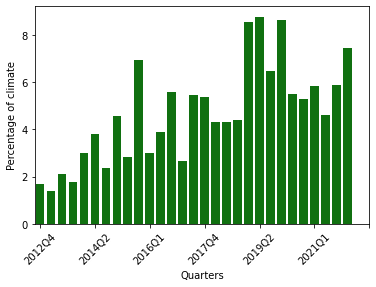

In [13]:
import seaborn as sns
viewQ["Quarters"] = viewQ["date2"]
viewQ["Percentage of climate"] = viewQ["percentage_climate"]
g = sns.barplot(data=viewQ, x="Quarters", y="Percentage of climate", color="green")
plt.xticks([0, 5, 10, 15, 20, 25, 30],rotation=45)
#viewQ.plot()
#view2.plot()
#plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '2012'),
  Text(1, 0, '2013'),
  Text(2, 0, '2014'),
  Text(3, 0, '2015'),
  Text(4, 0, '2016'),
  Text(5, 0, '2017'),
  Text(6, 0, '2018'),
  Text(7, 0, '2019'),
  Text(8, 0, '2020'),
  Text(9, 0, '2021'),
  Text(10, 0, '2022')])

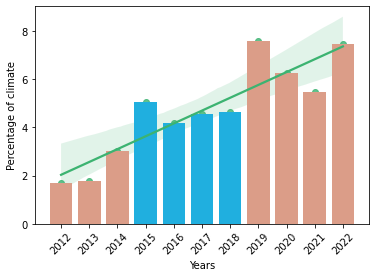

In [14]:
view2["Years"] = view2["date2"]
view2["Percentage of climate"] = view2["percentage_climate"]
g = sns.barplot(data=view2, x="Years", y="Percentage of climate", palette=['darksalmon', 'darksalmon', 'darksalmon', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'darksalmon', 'darksalmon', 'darksalmon'])
view2["Years"] = range(len(view2))
g = sns.regplot(x="Years", y="Percentage of climate", data=view2, color="mediumseagreen")

plt.xticks(rotation=45)

In [29]:
print(df_selection[(df_selection["text"].str.contains("corona", case=False))&(df_selection["year"]=="2016")]["text"][84894])

Tak for det. I filmen »Kærlighed ved første hik« møder vi den unge mand Viktor, som, efter at have gjort succesfuld kur til den smukke Anja, i en scene skal købe den nødvendige beskyttelse, i tilfælde af at han skulle få held til at tage forholdet til Anja til det næste trin i et ungdomskæresteforhold. Det er imidlertid en svær opgave for den unge Viktor, da han er noget pinlig berørt over at skulle købe denne beskyttelse. I stedet forlader han butikken med Coronaer og kondivand – ak, den arme stakkel. Og han skulle ellers have købt noget, som en ung mand måske ellers kunne finde noget stolthed i at have brug for. Forestil jer så, at den arme Viktor havde været i en mindre glædelig situation end at have gjort kur til den skønne Anja, og at han havde reddet sig en sygdom, som han ikke var for stolt af. Det ville næppe have gjort situationen ved disken nemmere eller sjovere for Viktor. Måske ville han endda være endt med igen at forlade butikken med uforrettet sag og med schweizerdrops o

In [23]:
df_selection[(df_selection["text"].str.contains("corona", case=False))|(df_selection["text"].str.contains("covid", case=False))].groupby("year").count()

,speaker,politician,title,party,text,date,y_pred,month,id,climate,non-climate
year,,,,,,,,,,,
2016,1,1,1,1,1,1,1,1,1,1,1
2020,2480,2480,2480,2480,2480,2480,2480,2480,2480,2480,2480
2021,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849
2022,91,91,91,91,91,91,91,91,91,91,91


In [24]:
print(2480/(1767+26598)) ## COVID 2020
print(1849/(1443+25016)) ## COVID 2020
yearly

0.08743169398907104
0.06988170376809404


,climate,non-climate,percentage_climate
date,,,
2012,118,6832,1.697842
2013,325,17932,1.780139
2014,528,16861,3.036402
2015,997,18761,5.046057
2016,1137,26044,4.183069
2017,1105,23157,4.554447
2018,946,19504,4.625917
2019,1432,17484,7.570311
2020,1767,26495,6.252211
